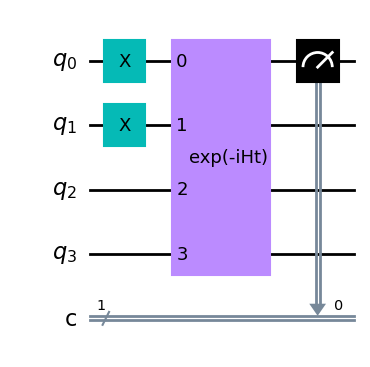

In [2]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import Aer, transpile, assemble, execute
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator

# Constants and simulation parameters
N_sites = 4  # Number of qubits
delta_m_squared = 0.5
omega_a = np.full(N_sites // 2, delta_m_squared)
omega_b = np.zeros(N_sites // 2)
omega = np.concatenate((omega_a, omega_b))
tolerance = 5e-1
# Define time steps
times = np.linspace(0, 10, 1000)  # Extending the time range to 10
τ = times[1] - times[0]  # Time step
shots = 5125967
backend = AerSimulator(method = 'automatic')
# E = 1
# omega = np.array([delta_m_squared / (2 * E) for _ in range(N_sites)])  # omega for each qubit
B = [0, 0, -1]  # Magnetic field B = [1, 0, 0] for all sites

# Constants for Rogerro's fit (corresponding to Δω = 0.25)
a_t = 1.224
b_t = 0
c_t = 1.62
   
# Define parameters for H_SI
mu = 1.0
interaction_strength = mu / (2 * N_sites)
H_SI = 0
H_vac = 0
for i in range(N_sites -1):
    for j in range(i + 1, N_sites):
        
        # H_vac terms for site i
        Xi = (omega[i] / 2) * B[0] * Pauli(f'{"I"*i}X{"I"*(N_sites-i-1)}').to_matrix()
        Yi = (omega[i] / 2) * B[1] * Pauli(f'{"I"*i}Y{"I"*(N_sites-i-1)}').to_matrix()
        Zi = (omega[i] / 2) * B[2] * Pauli(f'{"I"*i}Z{"I"*(N_sites-i-1)}').to_matrix()
        H_vac += (1/(N_sites-1)) * (Xi + Yi + Zi)
        
        # H_vac terms for site j
        Xj = (omega[j] / 2) * B[0] * Pauli(f'{"I"*j}X{"I"*(N_sites-j-1)}').to_matrix()
        Yj = (omega[j] / 2) * B[1] * Pauli(f'{"I"*j}Y{"I"*(N_sites-j-1)}').to_matrix()
        Zj = (omega[j] / 2) * B[2] * Pauli(f'{"I"*j}Z{"I"*(N_sites-j-1)}').to_matrix()
        H_vac += (1/(N_sites-1))* (Xj + Yj + Zj)
        
        XX = Pauli(f'{"I"*i}X{"I"*(j-i-1)}X{"I"*(N_sites-j-1)}').to_matrix()
        YY = Pauli(f'{"I"*i}Y{"I"*(j-i-1)}Y{"I"*(N_sites-j-1)}').to_matrix()
        ZZ = Pauli(f'{"I"*i}Z{"I"*(j-i-1)}Z{"I"*(N_sites-j-1)}').to_matrix()
        H_SI += interaction_strength * (XX + YY + ZZ)

# Total Hamiltonian H = H_vac + H_SI
H_total = H_vac + H_SI

def evolve_and_measure_circuit(time, H_total):
    U = Operator(expm(-1j * H_total * time))
    qc = QuantumCircuit(N_sites, 1) # Measure just the first qubit
    half_N_sites = N_sites // 2  # Calculate the size of the first half of the chain
    qc.x(range(half_N_sites))  # Apply X gate to the  first half of the qubits i.e. first and second qubits to create |1100> state for 4 N_sites
    qc.unitary(U, range(N_sites), label="exp(-iHt)")
    qc.measure(0, 0)  # Measure just tthe first qubit
    return qc

# Generate and visualize the circuit for a specific time
qc = evolve_and_measure_circuit(τ , H_total) # τ  used here to see the qc at each time step
qc.draw(output='mpl', style='clifford')

# Display the plot
# plt.show()



In [3]:

# Simulation and expected value calculation
sigma_z_values = []
survival_probabilities = []

for t in times:
    qc = evolve_and_measure_circuit(t, H_total)
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)

    # Calculate expectation value of sigma_z for the first qubit
    sigma_z = 0
    for outcome, count in counts.items():
        if outcome[0] == '0':
            sigma_z += count / shots
        else:
            sigma_z -= count / shots
    
    # Calculate survival probability
    survival_probability = (1 - sigma_z) / 2
    
    # Append values to the respective lists
    sigma_z_values.append(sigma_z)
    survival_probabilities.append(survival_probability)


def find_first_local_minima_index(arr):
    n = len(arr)
    for i in range(1, n - 1):
        if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
            return i
    return -1

# Index of the first minimum of the survival probabilities
i_first_local_min = find_first_local_minima_index(survival_probabilities)

# Writing if_else statement to communicate if local minima (not) found
if i_first_local_min != -1:
    print(f"Index of the first local minimum: {i_first_local_min}")
else:
    print("No local minimum found in the array.")

# Time at which the first minimum survival probability is reached
t_min = τ * i_first_local_min - τ
print(f"Corresponding time of first minimum index= {t_min}")
    
t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
print("t_p_Rog= ", t_p_Rog)

# Assert condition
# assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

# Plot the survival probability at site 1 against time
plt.plot(times, survival_probabilities, label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability at site 1')
plt.title('Survival Probability at site 1 vs Time (4 Qubits, All-to-All Interaction)')

# Add scatter point for Rogerro's fit
plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

# Add scatter point for the first local minimum
if i_first_local_min != -1:
    plt.scatter([t_min], [survival_probabilities[np.abs(times - t_min).argmin()]], color='blue', label="First Local Min", zorder=5)

plt.legend(loc="upper right")
plt.grid(True)
plt.show()